#Introduction

We'd like to see what the coverage of our spikes looks like.

In [1]:
import pandas
import numpy
import os

import pysam
from matplotlib import pylab
pylab.style.use('ggplot')

import models

import load_spike_table

In [2]:
%matplotlib inline

Mount the single-cell project directory if needed.

In [3]:
numpy.linspace(0, 333, 101, dtype=int)

array([  0,   3,   6,   9,  13,  16,  19,  23,  26,  29,  33,  36,  39,
        43,  46,  49,  53,  56,  59,  63,  66,  69,  73,  76,  79,  83,
        86,  89,  93,  96,  99, 103, 106, 109, 113, 116, 119, 123, 126,
       129, 133, 136, 139, 143, 146, 149, 153, 156, 159, 163, 166, 169,
       173, 176, 179, 183, 186, 189, 193, 196, 199, 203, 206, 209, 213,
       216, 219, 223, 226, 229, 233, 236, 239, 243, 246, 249, 253, 256,
       259, 263, 266, 269, 273, 276, 279, 283, 286, 289, 293, 296, 299,
       303, 306, 309, 313, 316, 319, 323, 326, 329, 333])

In [4]:
samfile = pysam.AlignmentFile("/home/diane/proj/single-cell/barbara-wold:15270/Aligned.sortedByCoord.out.bam", "rb")

In [5]:
def get_spike_length(samfile, spike_name):
    return samfile.lengths[samfile.gettid(spike_name)]

def spike_coverage_pileup(samfile, spike_name):
    spike_length = get_spike_length(samfile, spike_name)
    coverage = []
    windows = 101
    coordinates = numpy.linspace(0, spike_length, windows, dtype=int)

    for i in range(windows - 1):
        start = coordinates[i]
        stop = coordinates[i+1]
        window = []
        for pileup in samfile.pileup(spike_name, start, stop, truncate=True):
            window.append(pileup.nsegments)
        coverage.append(numpy.mean(window))
            
    coverage = pandas.Series(coverage, name=spike_name)
    return coverage

In [6]:
def spike_coverage_count(samfile, spike_name):
    spike_length = samfile.lengths[samfile.gettid(spike_name)]
    coverage = []
    windows = 101
    coordinates = numpy.linspace(0, spike_length, windows, dtype=int)

    for i in range(windows - 1):
        start = coordinates[i]
        stop = coordinates[i+1]
        window = []
        #for pileup in samfile.pileup(spike_name, start, stop, truncate=True):
        #    window.append(pileup.nsegments)
        #coverage.append(numpy.mean(window))
        coverage.append(samfile.count(spike_name, start, stop))
            
    coverage = pandas.Series(coverage, name=spike_name)
    return coverage

In [7]:
def all_spike_coverage(samfile, coverage_func=spike_coverage_pileup):
    spikes = {}
    for name in samfile.references:
        if name.startswith('ERCC'):
            spikes[name] = coverage_func(samfile, name)
    
    return pandas.DataFrame(spikes)

/usr/lib/python3/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


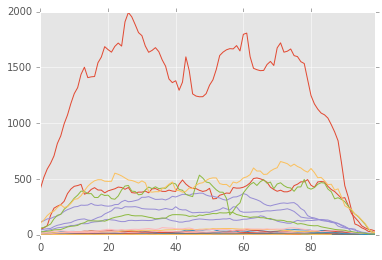

In [8]:
all_spikes = all_spike_coverage(samfile, coverage_func=spike_coverage_pileup)
all_spikes.dropna(how='all', axis=1).plot(legend=False)

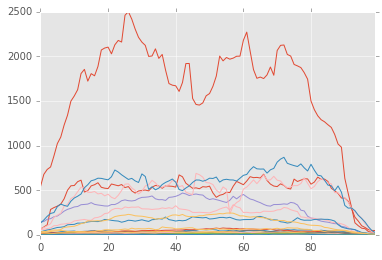

In [9]:
all_spikes = all_spike_coverage(samfile, coverage_func=spike_coverage_count)
all_spikes.dropna(how='all', axis=1).plot(legend=False)

Well that's hard to read. whats going on with the low end? Sean suggested breaking the plot into several size classes to make it easier to visualize whats going on. 

In [10]:
spikes = load_spike_table.load_caltech_single()

In [11]:
low = spikes[spikes < 10].dropna()
mid = spikes[(spikes >= 10) & (spikes < 200)].dropna()
high = spikes[spikes >= 200].dropna()

#Load Pool Split experiments

In [12]:
libraries = models.load_library_tables(
    [os.path.expanduser('~/proj/single-cell/poolsplit-libs.tsv'),
    ])
experiments = models.load_experiments(
    [os.path.expanduser('~/proj/single-cell/poolsplit-experiments.tsv'),
    ])

#Plot Mm_layer_V_pyramidal_poolsplit

In [13]:
library_spikes = {}
for library_id in experiments['Mm_layer_V_pyramidal_poolsplit']:
    print(libraries.ix[library_id].analysis_dir)
    samfile = pysam.AlignmentFile(
        os.path.join("/home/diane/proj/single-cell", 
                     libraries.ix[library_id].analysis_dir, 
                     "Aligned.sortedByCoord.out.bam"),
        "rb")
    library_spikes[library_id] = all_spike_coverage(samfile)


barbara-wold:15304
barbara-wold:15305
barbara-wold:15306
barbara-wold:15307
barbara-wold:15308
barbara-wold:15309
barbara-wold:15310
barbara-wold:15311
barbara-wold:15356
barbara-wold:15357
barbara-wold:15358
barbara-wold:15359
barbara-wold:15360
barbara-wold:15361
barbara-wold:15362


/usr/lib/python3/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


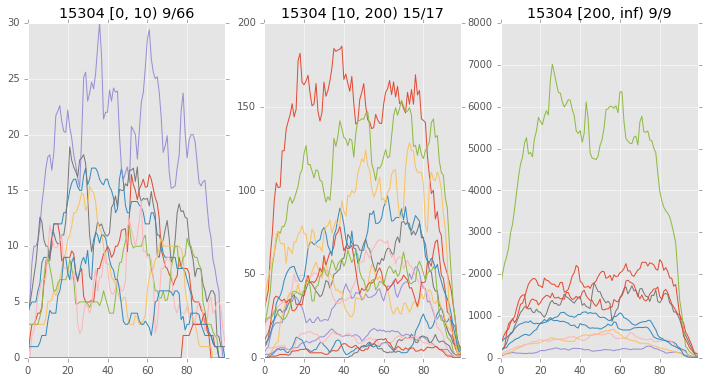

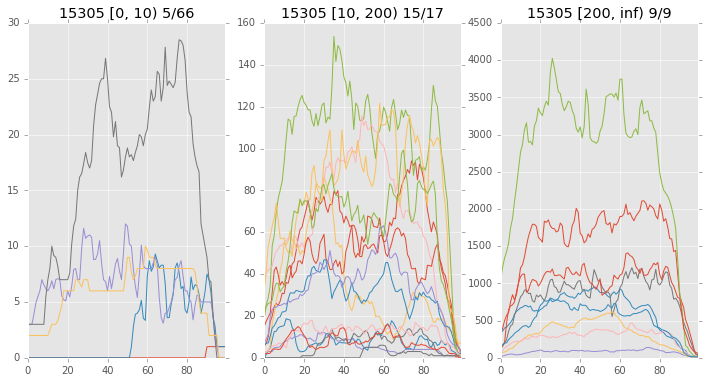

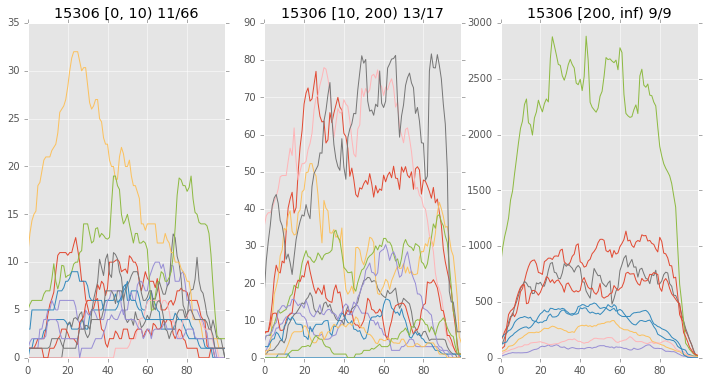

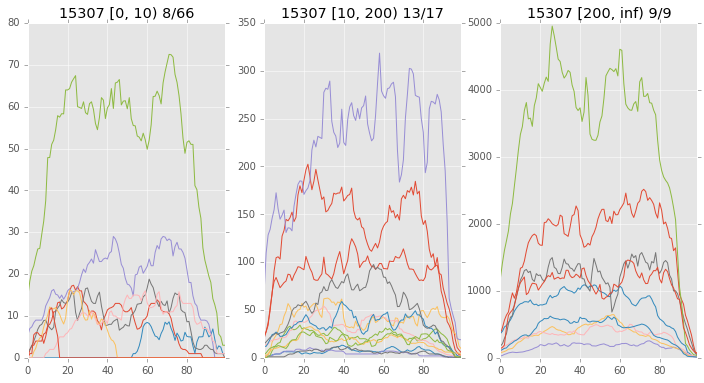

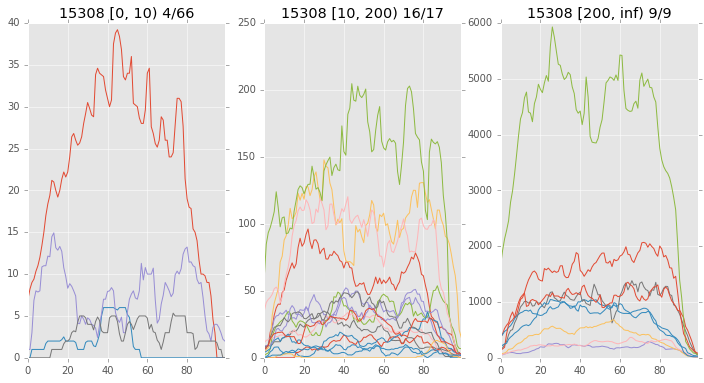

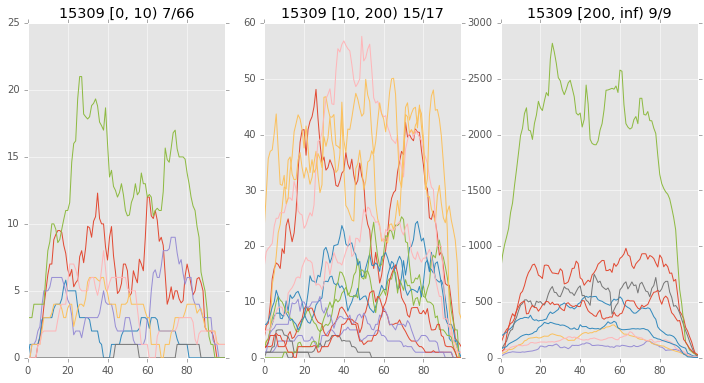

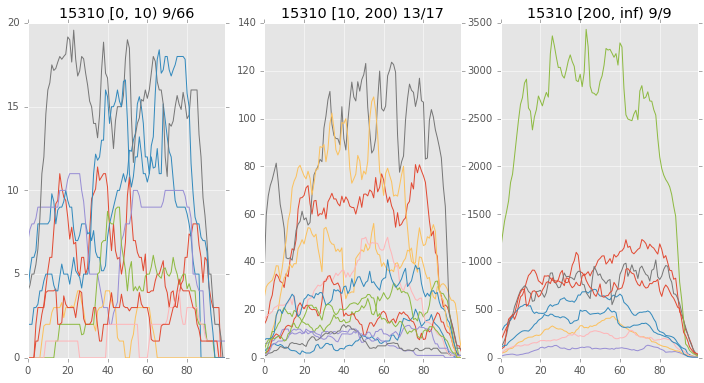

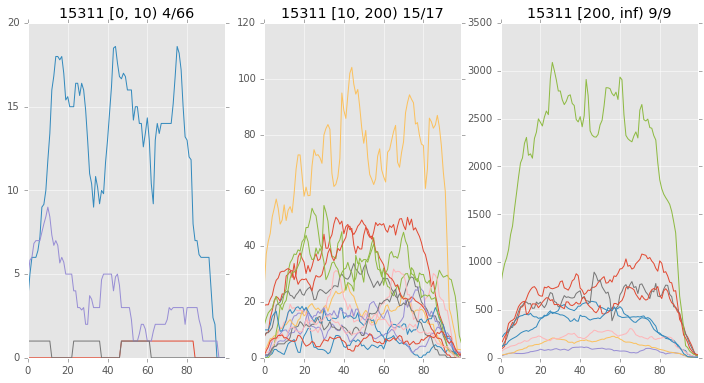

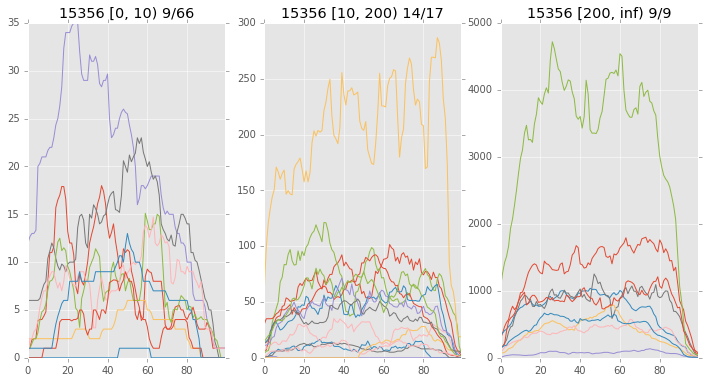

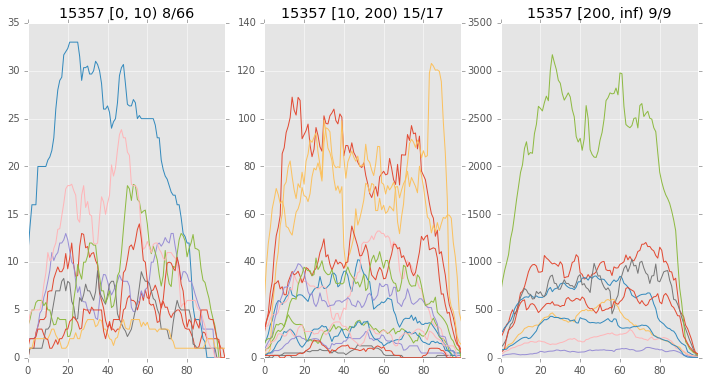

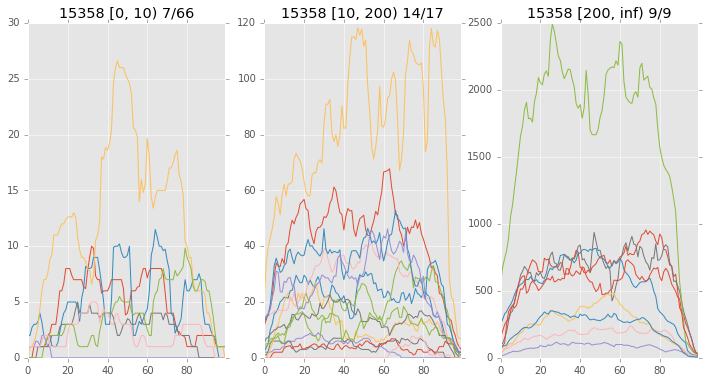

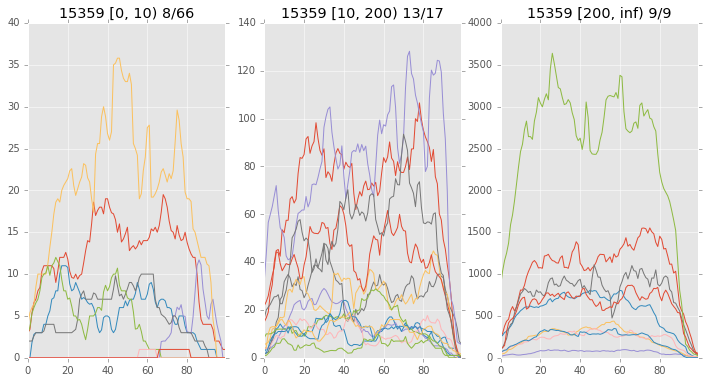

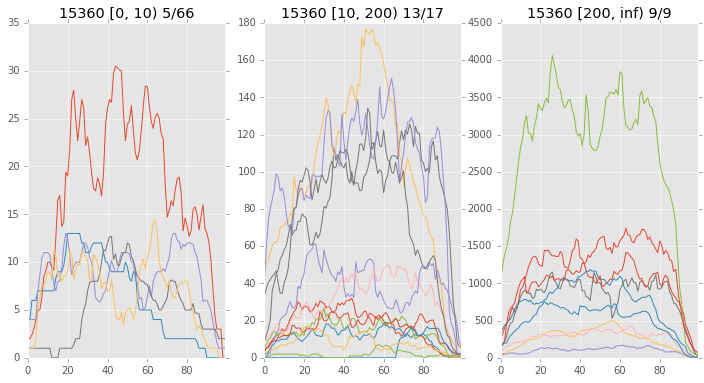

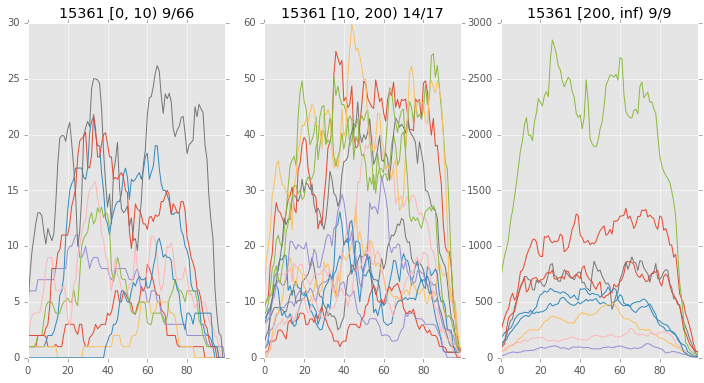

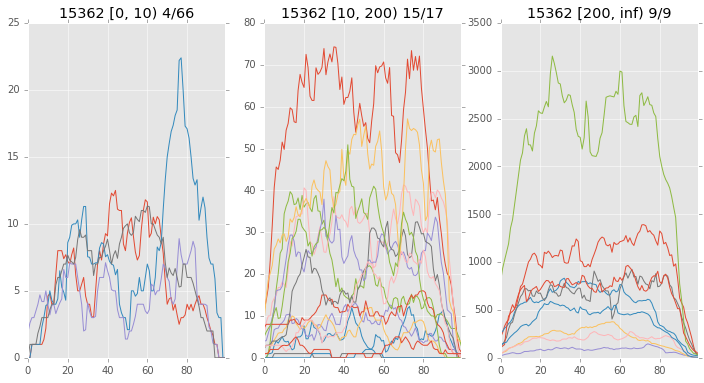

In [14]:
for library_id in sorted(library_spikes):
    m = library_spikes[library_id]
    spike_classes = {
        '[0, 10)': m[list(low.index)],
        '[10, 200)': m[list(mid.index)],
        '[200, inf)':m[list(high.index)]
    }
    fig, axes = pylab.subplots(1,3, figsize=(12,6))
    for i, abundance in enumerate(['[0, 10)', '[10, 200)', '[200, inf)']):
        nonzero = spike_classes[abundance][spike_classes[abundance] > 0].dropna(how='all', axis=1)
        nonzero.fillna(0).plot(ax = axes[i], legend=False)
        present = len(nonzero.columns)
        total = len(spike_classes[abundance].columns)
        axes[i].set_title('{} {} {}/{}'.format(library_id, abundance, present, total))
    pylab.show(fig)


In [15]:
pandas.set_option('display.max_rows', 500)

In [16]:
get_spike_length(samfile, 'ERCC-00062')

1023

In [17]:
spike_classes['[0, 10)'][spike_classes['[0, 10)'] > 0].dropna(how='all', axis=1)

,ERCC-00062,ERCC-00053,ERCC-00034,ERCC-00071
0,NaN,NaN,1.900000,NaN
1,NaN,NaN,2.600000,1.000000
2,1.000000,1.000000,3.000000,1.000000
3,1.000000,1.000000,3.000000,1.000000
4,1.000000,1.000000,3.500000,1.000000
5,1.000000,1.000000,4.000000,1.833333
6,1.000000,1.000000,4.700000,2.333333
7,1.000000,2.300000,4.200000,3.000000
8,1.363636,3.000000,4.200000,3.000000
9,2.200000,3.900000,5.000000,3.000000


In [18]:
import bokeh
from bokeh.plotting import figure, show, ColumnDataSource, output_file
from bokeh.io import output_notebook
import bokeh.io
import bokeh.resources
import bokeh.charts
from bokeh.models import HoverTool

In [19]:
output_notebook()

Loading BokehJS ...

In [21]:
f = figure()

In [22]:
filtered = spike_classes['[0, 10)'][spike_classes['[0, 10)'] > 0].dropna(how='all', axis=1)

f = bokeh.charts.Line(x=filtered.index, y=filtered.fillna(0))
show(f)


TypeError: 'NoneType' object is not subscriptable

In [24]:
# (dict, OrderedDict, lists, arrays and DataFrames are valid inputs)
xyvalues = numpy.array([[2, 3, 7, 5, 26], [12, 33, 47, 15, 126], [22, 43, 10, 25, 26]])

line = bokeh.charts.Line(xyvalues, title="line", legend="top_left", ylabel='Languages')
show(line)

ImportError: No module named 'ipykernel'

In [ ]:
spike_classes['[0, 10)'][spike_classes['[0, 10)'] > 0].dropna(how='all',axis=1)